Pseudoplastic subduction with a weak and thin upper asthenosphere (WL) in a 2-D retangular box: Carluccio et al. 2019
=====

These notebook generates subducion models from the Carluccio et al. 2019 in Underworld2. The notebooks are broken into a general notebook for reproducing the models from scratch and post-analysis notebooks which look at the results Underworld2 gives for each case after running to steady state stage. 



Comparison between the subduction time evolution of the reference model-NO WL (RM) and a model with a WL.
-------

| RM- $\eta_M/\eta_{WL} = 10^{0}$| WL- $\eta_M/\eta_{WL} = 10^{2}$ |
| :---: | :---: | 
| ![alt](videorm.gif) |![alt](videowl.gif) |

Case 1: Pseudo-Plastic rheology
-------

This case has a Pseudo-Plastic rheology. Plasticity is impleted near the surface and linear rheology applies deeper in the lithosphere and mantle. 
We assume Byerlee's law which describes the increase in the maximum strength of the upper crustal rocks with increasing confining pressure (depth). 
We also assume an approximation of the Drucker-Prager yield criterion, the so-called depth-dependent (henceforth denoted as DD), which introduces a friction angle and depends only on the lithostatic pressure and neglects the dynamic component. 
The rheology is described by:
    
\begin{equation}
    \eta_{eff} =  
        \begin{cases}
              \eta_0 & \tau < \tau_\textrm{y} \\
              \frac {\tau_\textrm{y}}{2\dot \varepsilon_{II}}  & \textrm{otherwise}
        \end{cases}
\end{equation}

$\tau_{y}$, $\eta_\text{eff}$ and $ \dot \varepsilon_{II} $ are the yield stress, the effective viscosity of the plastic branch and the second invariant of the strain rate tensor, respectively.
    
$\tau_\textrm{y}$ is given by:

\begin{equation}
     \tau_\textrm{y} = \tau_{0}+\mu \text{p}_\text{lith}
\end{equation}


<img src="setup.png">

Scaling based on Newton's second law of motion:
-------
The dimensional analysis is computed accordingly with the Newton second low motion from SI to dimensionless values and viceversa:

    

|**Values **<br> |**Symbol **<br> |**Scaling Factors**<br>  | 
| --- | --- | --- | 
 |Time | $t_{SF}$ | $\eta_{SF}/\sigma_{SF}$|
    |Force |  $F_{SF}$|  $\sigma_{SF}/(l_{SF}^{2}$|
    |Acceleration |  $g_{SF}$   | $l_{SF}/t_{SF} /t_{SF}$  |
    | Mass |  $m_{SF}$| $F_{SF}/g_{SF}$   |
    



References
-----
1. R. Carluccio, B. Kaus, F. A. Capitanio, L. N. Moresi, The impact of a very weak and thin upper asthenosphere on subduction motions





In [28]:
#==========================================================================
# IMPORT LIBRARIES                #
#==========================================================================
import underworld as uw
import math
from underworld import function as fn
import numpy as np
import h5py
import time
import mpi4py
import sys
import os
import glucifer
from scipy.special import erf

#==========================================================================
# Import library os
#==========================================================================
outputPath = os.path.join(os.path.abspath("."),"m1data/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [29]:
#==========================================================================
# Resolution
#==========================================================================
xRes      =  256
zRes      =  128

In [30]:
#==========================================================================
# Initialise time variables/ restart
#==========================================================================
# Inizialise time variables
time         = 157.              # Initial time
step         = 0                 # Initial timestep
maxSteps     = 2           # Maximum timesteps (201 is recommended)
steps_output = 1                 # output every 10 timesteps
nsteps       = (maxSteps /steps_output)+1   #because i want 0 step

In [31]:
#==========================================================================
# Monitor simulation time
#==========================================================================
comm = mpi4py.MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

## Start writing log
if rank==0:
    import time as timekeeper
    tStart = timekeeper.time()
    fw = open("Log.txt","w")
    fw.write("%s \n" %(timekeeper.ctime()))
    fw.write("Running on %i proc(s). \n" %size)
    fw.close()


In [32]:
#==========================================================================
# Retrive simulation current status and time
#==========================================================================
def getsubProp():
    #'''gets info from slab property file and gives back time, trench, tip and step values''' #
    #if uw.rank()==0:
    
    
    # Initialise new list objects
    istep        = []
    itime        = []
    X_trench     = []
    Z_slabTip    = []
    step, time  = 0.,157.
    cstep=step
        

    return step, time,istep, itime, X_trench,Z_slabTip,cstep

step,  time, istep, itime, X_trench, Z_slabTip, cstep = getsubProp()



In [33]:
#==========================================================================
# Characteristics Values          ##Scaling based on Newton's second law of motion:
#==========================================================================
l_D            =   1.e5        #   [m] 100km
eta_D          =   1.e21       #   [Pa s]
sigma_D        =   1.e10       #   [Pa] 10 GPa ~ 250 km depth
Temperature_D  =   1000       #   [K]


#==========================================================================
# Reference choosen values
#==========================================================================
l_DL            =   1.
eta_DL          =   1.
sigma_DL        =   1.
Temperature_DL  =   1.


#==========================================================================
# Trivial Scaling Factor
#==========================================================================
l_SF            =   l_DL     / l_D
eta_SF          =   eta_DL   / eta_D
sigma_SF        =   sigma_DL / sigma_D
Temperature_SF  =   Temperature_DL / Temperature_D

#==========================================================================
# Basic scaling coefficient LAMEM
#==========================================================================
time_SF         =   eta_SF/sigma_SF
force_SF        =   sigma_SF*(l_SF*l_SF)
g_SF            =   l_SF/time_SF/time_SF
m_SF            =   force_SF/g_SF

#==========================================================================
# Other scaling coefficients
#==========================================================================
angle_SF           = math.pi/180;
area_SF            = l_SF*l_SF
volume_SF          = area_SF*l_SF
energy_SF          = force_SF*l_SF
power_SF           = energy_SF/time_SF
v_SF               = l_SF/time_SF
strain_rate_SF     = 1.0/time_SF
rho_SF             = m_SF/volume_SF

#==========================================================================
# Thermal scaling coefficients
#==========================================================================
Thermal_conductivity_SF         = power_SF/l_SF /Temperature_SF
Thermal_expansion_SF            = 1/Temperature_SF
capacity_SF                     = energy_SF/ Temperature_SF / m_SF
Thermal_diffusivity_SF          = (l_SF*l_SF)  /  time_SF #in uw2

#==========================================================================
# Additional UNITS
#==========================================================================
yr     = 3600.0*24.0*365.25;
Myr    = 1e6*yr;
km     = 1e3;
cm     = 1.e-2;
cm_yr  = cm/yr;
MPa    = 1e6;
mW     = 1e-3;
K      = 273.15
#timeMyr                = []/Myr   #gives time in second
#length_Km              = l_D/km  # gives you back the value in Km
#stressMPa              = sigma_SF/MPa   #gives you Pa

#==========================================================================
# Dimensional physical data
#==========================================================================
DII_ref                     =   1e-16

boxLength                   =    4000.0     * km
boxHeight                   =    660.0      * km
l_max_op                    =    1750.0     * km
l_min_op                    =    - 1000.0   * km
Depth_slab                  =    - 256.2536 * km
l_op                        =    - 310.0    * km
ThickCrust                  =    10.0       * km
ThickOP                     =    100.0      * km
ThickWL                     =    30.0       * km
xmarker                     =    0.          * km

upperMantleViscosity        =    2.5e21
slabViscosity               =    2.5e23
crustViscosity              =    2.5e23
initialViscosity            =    1e22
wlViscosity                 =    2.5e19

UpperViscosityCutoff        =    2.5e23
LowerViscosityCutoff        =    2.5e18

mantleDensity               =    3220.0
slabDensity                 =    3300.0
crustDensity                =    3300.0
wlDensity                   =    3220.0

Gravity                     =    -10
cohesion                    =    20.           * MPa            # Stress is in megaPa with cap S

alpha_plastic               =    30.

#friction_angle = 30 * 1/angle_SF

dt                          =     0.5          * Myr

# Elasticity
Shear_modulus               =     5.e10         # Pa
# choosing a value of dT_e between that one of the strongest and the weakest material
relaxation_time             =     2.5e26/Shear_modulus                        # this corresponds to 15.844 yr
dt_e                        =     relaxation_time / 10.                       # this corresponds to 1.5844 yr

#==========================================================================
# Set Temperature variables 
#==========================================================================
# Initialise T
M_gradient              =   0.3
L_gradient              =   27.
kappa_diffusivity       =   1.e-6            # thermal material parameter, thermal diffusivity (unit m2/s)
kappa_conductivity      =   3.
ThermalAge              =   70               * Myr

t_surface               =   20.              + K
TLAB                    =   1300.            + K
T_M                     =   1280.            + K
T_findZ                 =   1350.            + K
Temp_bottom             =   1463.             + K            # Temperature @ bottom with grad in the upper mantle; side BC's are flux-free

alpha_rho               =   3.e-5
capacity                =   914.                            # [J/K/kg)]
R_gas                   =   8.3145                          # Universal gas constant

rho0_D                       =   3250.
rho0Crust_D                  =   2900.

#==========================================================================
# Getting dimension-less values
#==========================================================================
boxLength_DL              =   boxLength                         * l_SF
boxHeight_DL              =   boxHeight                         * l_SF
l_max_op_DL               =   l_max_op                          * l_SF
l_min_op_DL               =   l_min_op                          * l_SF
Depth_slab_DL             =   Depth_slab                        * l_SF
l_op_DL                   =   l_op                              * l_SF
ThickCrust_DL             =   ThickCrust                        * l_SF
ThickOP_DL                =   ThickOP                           * l_SF
ThickWL_DL                =   ThickWL                           * l_SF

upperMantleViscosity_DL   =   upperMantleViscosity              * eta_SF
slabViscosity_DL          =   slabViscosity                     * eta_SF
crustViscosity_DL         =   crustViscosity                    * eta_SF
wlViscosity_DL            =   wlViscosity                       * eta_SF
initialViscosity_DL       =   initialViscosity                  * eta_SF
LowerViscosityCutoff_DL   =   LowerViscosityCutoff              * eta_SF
UpperViscosityCutoff_DL   =   UpperViscosityCutoff              * eta_SF

mantleDensity_DL          =   mantleDensity                     * rho_SF
slabDensity_DL            =   slabDensity                       * rho_SF
crustDensity_DL           =   crustDensity                      * rho_SF
wlDensity_DL              =   wlDensity                         * rho_SF
rho0_DL                   =   rho0_D                            * rho_SF
rho0Crust_DL              =   rho0Crust_D                       * rho_SF

DII_ref_DL1               =   DII_ref                           * (1.0/time_SF )
g_DL                      =   Gravity                           * g_SF
cohesion_DL               =   cohesion                          * sigma_SF

dt_DL                     =   dt                                * time_SF
DII_ref_DL                =   DII_ref                           * strain_rate_SF

# Temperature data
ThermalAge_DL             =   ThermalAge                        * time_SF
Temp_bottom_DL            =   Temp_bottom                       * Temperature_SF
TLAB_DL                   =   TLAB                              * Temperature_SF
T_M_DL                    =   T_M                               * Temperature_SF
T_surface_DL              =   t_surface                         * Temperature_SF
T_findZ_DL                =   T_findZ                           * Temperature_SF

k_cond_DL                 =   kappa_conductivity                * Thermal_conductivity_SF   # Therma conductivity
k_DL                      =   kappa_diffusivity                 * Thermal_diffusivity_SF
cp_DL                     =   capacity                          * capacity_SF
Thermaldiffusivity        =   k_DL
alpha_rho_DL              =   alpha_rho                         * (1./Temperature_SF)        # thermal expansion

dt_e_DL                   =   dt_e                              * time_SF
Shear_modulus_DL          =   Shear_modulus                     * sigma_SF
relaxation_time_DL        =   relaxation_time                   * time_SF                   # tmax_ad <= dt_e, and tmaxstrong<dt_e<tmaxweak   -Kaus and Torsten 2007


# getting DL drho for slab
drho_slab_crust           =  (slabDensity_DL-mantleDensity_DL)/rho_SF # this is 80
drho_mantle_wl            =  (mantleDensity_DL-mantleDensity_DL)/rho_SF # this is 0


In [34]:
#==========================================================================
# DOMAIN PARAMETERS (non-DIMENSIONAL)
#==========================================================================
dim       =   2
L         =   boxLength_DL
H         =   boxHeight_DL
dx        =   boxLength_DL/xRes
dz        =   boxHeight_DL/zRes
x_left    =   -L/2                 #  coord of the left margin
z_bot     =   -H                   #  coord of the bottom margin
z_surface =   -H+H


#==========================================================================
# INITIALIZE MESH AND MESH VARIABLES
#==========================================================================
mesh                = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                               elementRes  = (xRes, zRes),
                                               minCoord    = (x_left , z_bot),
                                               maxCoord    = (-x_left, z_surface) )

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

#==========================================================================
# Set initial conditions
#==========================================================================
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureField.data[:]    = 0.
pressureField0 = pressureField

In [35]:
#==========================================================================
# Boundary conditions
#==========================================================================
iWalls      = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls      = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
bottomWall  = mesh.specialSets["MinJ_VertexSet"]
topWall     = mesh.specialSets["MaxJ_VertexSet"]
allWalls    = iWalls + jWalls
freeslipBC  = uw.conditions.DirichletCondition( variable      = velocityField,
                                               indexSetsPerDof = (iWalls, jWalls) )

# Possibly this is a no- heat flux BC
tempBC      = uw.conditions.DirichletCondition( variable      = temperatureField,
                                               indexSetsPerDof = (jWalls,) )

In [36]:
#==========================================================================
#==========================================================================
# Set plate thickness based on its age
#==========================================================================
#Define thickness OL base on half cooling method
temperatureField.data[:]    =   0.
minz                        =   2.32*math.sqrt(kappa_diffusivity*ThermalAge)*l_SF
z_UC1                       =   -minz
z_UC3                       =   z_UC1  -ThickWL_DL
z_surface                   =   z_bot+H;
z_UC0                       =   -ThickCrust_DL


#==========================================================================
# Setup global material swarm
#==========================================================================
# Global swarm
swarm                  = uw.swarm.Swarm( mesh=mesh )
materialVariable       = swarm.add_variable( dataType="int", count=1 )
TemperatureSwarm       = swarm.add_variable( dataType="double", count=1 )
previousStress         = swarm.add_variable( dataType="double",count=3 )
dissipation            = swarm.add_variable( dataType="double",count=1 )
storedEneryRate        = swarm.add_variable( dataType="double",count=1)
surfaceSwarm        = uw.swarm.Swarm( mesh=mesh )
materialVar         = surfaceSwarm.add_variable( dataType="int", count=1 )
# create pop control object
pop_control         = uw.swarm.PopulationControl(swarm,aggressive=True,particlesPerCell=50)



In [37]:
#==========================================================================
# Allocate materials to particles
#==========================================================================
# initialise the 'materialVariable' data to represent two different materials.
UC0             =   0
UC1             =   1            # oceanic plate
UC2             =   3            # mantle
UC3             =   2            # wl

# crust
RectOcCrustcoord =  np.array([ ((l_max_op_DL-0.156) ,z_surface ), (l_min_op_DL ,z_surface ),(l_min_op_DL ,z_UC0), ((l_max_op_DL-0.156) ,z_UC0) ])
alpha            =  -34.*math.pi/180
R                =  np.array([ [(math.cos(alpha)), (math.sin(alpha))],[-(math.sin(alpha)), (math.cos(alpha))] ])
coordcrust       =  np.array([ [(l_op_DL),(0.), (0.), (l_op_DL)], [(0.),(0.),(z_UC0),(z_UC0)] ])
c_coord          =  np.dot(R,coordcrust)
c_coordX         =  c_coord[0, :] + l_min_op_DL
c_coordZ         =  c_coord[1, :]
c_coords         =  np.zeros((4,2))
c_coords[:,0]    =  c_coordX
c_coords[:,1]    =  c_coordZ
crustrec =  fn.shape.Polygon( RectOcCrustcoord )
crustdip =  fn.shape.Polygon( c_coords )

# crust tail
coordCrustTail  =   np.array([ ((l_max_op_DL-0.156) ,z_surface), (l_max_op_DL,z_surface),((l_max_op_DL-0.156),z_UC0 ) ])
crTail = fn.shape.Polygon( coordCrustTail  )


# slab
RectOcPlateCoord = np.array([ ((l_max_op_DL-1.7) ,z_UC0), (l_min_op_DL,z_UC0 ),(l_min_op_DL,z_UC1), ((l_max_op_DL-1.70),z_UC1) ])
coordslab        =  np.array([ [(l_op_DL),(0.), (0.), (l_op_DL)], [(z_UC0),(z_UC0),(z_UC1),(z_UC1)] ])
s_coord          =  np.dot(R,coordslab)
s_coordX         =  s_coord[0, :] + l_min_op_DL
s_coordZ         =  s_coord[1, :]
s_coords         =  np.zeros((4,2))
s_coords[:,0]    =  s_coordX
s_coords[:,1]    =  s_coordZ
slabrec = fn.shape.Polygon( RectOcPlateCoord  )
slabdip = fn.shape.Polygon( s_coords  )

# PlateTail
coordPlateTail        =   np.array([ ((l_max_op_DL-1.7) ,z_UC0), (l_max_op_DL-0.156,z_UC0),((l_max_op_DL-1.7),z_UC1 ) ])
ptTail = fn.shape.Polygon( coordPlateTail  )

# wl
RectWLCoord = np.array([ ((l_max_op_DL-1.7) ,z_UC1), (l_min_op_DL,z_UC1 ),(l_min_op_DL,z_UC3), ((l_max_op_DL-2.169),z_UC3) ])
coordwl        =  np.array([ [(l_op_DL),(0.), (0.), (l_op_DL)], [(z_UC1),(z_UC1),(z_UC3),(z_UC3)] ])
wl_coord          =  np.dot(R,coordwl)
wl_coordX         =  wl_coord[0, :] + l_min_op_DL
wl_coordZ         =  wl_coord[1, :]
wl_coords         =  np.zeros((4,2))
wl_coords[:,0]    =  wl_coordX
wl_coords[:,1]    =  wl_coordZ
wlrec = fn.shape.Polygon( RectWLCoord  )
wldip = fn.shape.Polygon( wl_coords  )

coordWlTail        =   np.array([ ((l_max_op_DL-2.169) ,z_UC1), ((l_max_op_DL-1.7),z_UC1),((l_max_op_DL-2.169),z_UC3 ) ])
wlTail = fn.shape.Polygon( coordWlTail )


modelTime = str("{0:.7f}").format(float(time)/ time_SF/ Myr/10000 )
Matmesh = uw.mesh.MeshVariable( mesh, 1 )

swarmLayout         = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# initialise everying to be upper mantle material
materialVariable.data[:] = UC2

# Change matieral index if the particle is not upper mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if wlTail.evaluate(tuple(coord)):
        materialVariable.data[index] = UC3
    if wldip.evaluate(tuple(coord)):
        materialVariable.data[index] = UC3
    if wlrec.evaluate(tuple(coord)):
        materialVariable.data[index] = UC3
    if slabdip.evaluate(tuple(coord)):
        materialVariable.data[index] = UC1
    if slabrec.evaluate(tuple(coord)):
        materialVariable.data[index] = UC1
    if ptTail.evaluate(tuple(coord)):
        materialVariable.data[index] = UC1
    if crustdip.evaluate(tuple(coord)):
        materialVariable.data[index] = UC0
    if crTail.evaluate(tuple(coord)):
        materialVariable.data[index] = UC0
    elif crustrec.evaluate(tuple(coord)):
        materialVariable.data[index] = UC0
#==========================================================================
# Setup surface material swarm-trench edge fixed on x tracking
#==========================================================================
# Surface swarm
# passive markers at the surface
surfacePoints        = np.zeros((1000,2))
surfacePoints[:,0]   = np.linspace(l_min_op_DL, l_max_op_DL, 1000)
surfacePoints[:,1]   = z_surface

surfaceSwarm.add_particles_with_coordinates( surfacePoints )

pass

# initialise everying to be None
#materialVar.data[:] = 999

# Change matieral index if the particle is not upper mantle

for index in range( len(surfaceSwarm.particleCoordinates.data) ):
    coord = surfaceSwarm.particleCoordinates.data[index][:]
    if crustdip.evaluate(tuple(coord)):
        materialVar.data[index] = UC0

    elif crustrec.evaluate(tuple(coord)):
        materialVar.data[index] = UC0




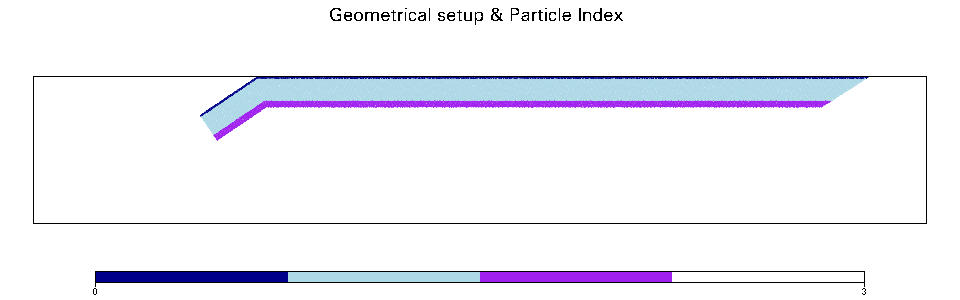

In [38]:
figParticle = glucifer.Figure(figsize=(960,300), title="Geometrical setup & Particle Index" )
figParticle.append( glucifer.objects.Points(swarm, materialVariable, pointSize=1, 
                                            colours='darkblue lightblue purple white', discrete=True) )

figParticle.show()

In [39]:
#==========================================================================
# Create a particle advection system
#==========================================================================
advector            = uw.systems.SwarmAdvector( swarm=swarm,                      velocityField=velocityField, order=2 )
advector2           = uw.systems.SwarmAdvector( swarm=surfaceSwarm,               velocityField=velocityField, order=2 )

In [40]:
#==========================================================================
# Mapping density
#==========================================================================
densityMap      = {     UC3 :  wlDensity_DL,
                        UC2 :  mantleDensity_DL,
                        UC1 :  slabDensity_DL,
                        UC0 : crustDensity_DL}

densityFn           = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat           = ( 0.0, H )

# now create a buoyancy force vector
buoyancyFn      = g_DL * densityFn * z_hat


# Get the lithostatic pressure term out
coordinateFn    = fn.coord()
Zcoord          = coordinateFn[1]
P_lithp         = (g_DL * densityFn * (Zcoord))

In [41]:
#==========================================================================
# Compute effective viscosity CREEP
#==========================================================================
#Chose viscosity approximation:
def RheoApprox(inv_eta1, inv_eta2,Approxtype):
    
    if Approxtype == 'eta_min':
        
        eta_approx      = fn.exception.SafeMaths( fn.misc.min(1./inv_eta1, 1./inv_eta2) )
        inv_eta_approx  = 1./eta_approx
    
    elif Approxtype == 'eta_arm':
        
        inv_eta_approx  =   (inv_eta1 + inv_eta2 +  (1./UpperViscosityCutoff) )
    
    return inv_eta_approx

In [42]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
#==========================================================================
# Implementing Phase rheology
#==========================================================================
Crust_rheo      = {  'Name':                       "Crust",
                    'Phase_ID':                 UC0,
                    'Viscous_Rheo_type':        "Const", # "Disl" ,
                    'Viscous_Rheo':              crustViscosity ,
                    'diff_disl_law':           "Dry_Olivine_disl_creep-Hirth_Kohlstedt_2003" ,
                    'elastic_parameters':       (relaxation_time_DL, dt_e_DL),
                    'plastic_parameters':       (alpha_plastic, cohesion_DL)
        }

Set_CrustRheo = objectview(Crust_rheo)


OceanLith_rheo  = {  'Name':                   'OceanicLithosphere',
                    'Phase_ID':             UC1,
                    'Viscous_Rheo_type':   "Const", #"Diff&Disl",
                    'Viscous_Rheo':         slabViscosity,
                    'diff_disl_law':        "Dry_Olivine_diff_creep-Hirth_Kohlstedt_2003,Dry_Olivine_disl_creep-Hirth_Kohlstedt_2003", #Dry_Olivine_disl_creep-Hirth_Kohlstedt_2003",
                    'elastic_parameters':   (relaxation_time_DL, dt_e_DL),#("None","None"),
                    'plastic_parameters':   (alpha_plastic, cohesion_DL)
            }

Set_OLRheo = objectview(OceanLith_rheo)


Mantle_rheo     = { 'Name':                  "OceanicLithosphere",
                    'Phase_ID':             UC2,
                    'Viscous_Rheo_type':    "Const",#"Diff&Disl",
                    'Viscous_Rheo':         upperMantleViscosity,
                    'diff_disl_law':        "Dry_Olivine_diff_creep-Hirth_Kohlstedt_2003,Dry_Olivine_disl_creep-Hirth_Kohlstedt_2003",
                    'elastic_parameters':   (relaxation_time_DL, dt_e_DL),#("None","None"),
                    'plastic_parameters':   (alpha_plastic, cohesion_DL)}

Set_MantleRheo = objectview(Mantle_rheo)

WL_rheo     = { 'Name':                  "WeakLayer",
                'Phase_ID':             UC3,
                'Viscous_Rheo_type':    "Const",#"Diff&Disl",
                'Viscous_Rheo':         wlViscosity,
                'diff_disl_law':        "Wet_Olivine_diff_creep-Hirth_Kohlstedt_2003,Wet_Olivine_disl_creep-Hirth_Kohlstedt_2003",
                'elastic_parameters':   (relaxation_time_DL, dt_e_DL),#("None","None"),
                'plastic_parameters':   (alpha_plastic, cohesion_DL)}

Set_WLRheo = objectview(WL_rheo)

In [43]:
def Implementing_viscous_rheo(viscous_rheo, eta_law_value):
    
    '''This function takes dimensional input to calculate DL constant or creep viscosity'''
    
    if viscous_rheo == 'Const' :
        print viscous_rheo
        
        eta_D           =     eta_law_value
        eta_DL          =     eta_D*eta_SF
    
    else:
        raise TypeError("No such viscous rheology : ",viscous_rheo)
    
    
    return eta_DL

In [44]:
def Implementing_viscousPlastic_rheo(alpha_plastic, C , eta, eII_Fn):
    
    if alpha_plastic!= "None":
        
        print 'VP'
        print "eta viscous"
        print eta/eta_SF
        
        friction_angle_DL         =  math.tan((alpha_plastic*math.pi)/180)
        yieldStressFn             =  cohesion_DL + (friction_angle_DL * P_lithp)
        eta_Pl                    =  0.5 * yieldStressFn / (eII_Fn+DII_ref_DL)              #real DII_ref 1.0e-18
    
        Approxtype = 'eta_min'
           
        eta_vp_DL      = LowerViscosityCutoff_DL +fn.exception.SafeMaths( fn.misc.min(eta_Pl,eta) )
        #eta_vep_DL                 =  fn.exception.SafeMaths( fn.misc.max(fn.misc.min(eta_Pl, eta_ve), min_viscosity))
        eta_vp_D       = eta_vp_DL/eta_SF 

    else:
        raise TypeError("No such viscous plastic parameters : ",alpha_plastic, cohesion_DL )
    
    return eta_vp_DL


In [45]:
#==========================================================================
# getting second invariant of the strain rate out
#==========================================================================
# plot them both see differences
eII_Fn                    =  fn.tensor.second_invariant(fn.tensor.symmetric(velocityField.fn_gradient ))
strainRateFn              =  fn.tensor.symmetric( velocityField.fn_gradient )
eII_FnD                   = eII_Fn/strain_rate_SF             

In [46]:
print "check phases rheology and values"
Crust_rheo['eta_viscous']       =   Implementing_viscous_rheo(Set_CrustRheo.Viscous_Rheo_type,Set_CrustRheo.Viscous_Rheo)
OceanLith_rheo['eta_viscous']   =   Implementing_viscous_rheo(Set_OLRheo.Viscous_Rheo_type,Set_OLRheo.Viscous_Rheo)
Mantle_rheo['eta_viscous']      =   Implementing_viscous_rheo(Set_MantleRheo.Viscous_Rheo_type,Set_MantleRheo.Viscous_Rheo)

WL_rheo['eta_viscous']      =   Implementing_viscous_rheo(Set_WLRheo.Viscous_Rheo_type,Set_WLRheo.Viscous_Rheo)

Crust_rheo['eta_vp']           =   Implementing_viscousPlastic_rheo(Set_CrustRheo.plastic_parameters[0],Set_CrustRheo.plastic_parameters[1],Set_CrustRheo.eta_viscous,eII_Fn)

print "pseudoplastic"
print Set_CrustRheo.eta_vp
print Set_OLRheo.eta_viscous
print Set_OLRheo.eta_viscous
print Set_WLRheo.eta_viscous
viscosityMap                    =   { UC3     : Set_WLRheo.eta_viscous,
                                    UC2     : Set_MantleRheo.eta_viscous,
                                    UC1     : Set_OLRheo.eta_viscous,
                                    UC0     : Set_CrustRheo.eta_vp
}

viscosityMapFn           = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )
devStress_2ndInvariantFn  = viscosityMapFn * eII_Fn

check phases rheology and values
Const
Const
Const
Const
VP
eta viscous
2.5e+23
pseudoplastic
250.0
250.0
0.025


In [47]:
#==========================================================================
# Tracing trench, slab tip position and slab velocities with time.
#==========================================================================
# Get Trench Positions
def GetTrenchPositions():
    fn_conditional = fn.branching.conditional( [ (materialVar < UC0+1., surfaceSwarm.particleCoordinates[0]),
                                                (                  True, 99999999. ) ] )
    testMM         =  fn.view.min_max(fn_conditional)
    dummy          =  testMM.evaluate(surfaceSwarm)
    x_trench       =  testMM.min_global()
    return x_trench

# Get slab tip position
def GetSlabTipPositions():
    fn_conditional_tip  = fn.branching.conditional( [ (materialVariable < UC1+0.1, swarm.particleCoordinates[1] ),
                                                     (                  True, 99999999. ) ] )
    testslabMM          = fn.view.min_max(fn_conditional_tip)
    dummy_tip           = testslabMM.evaluate(swarm)
    slab_tip            = testslabMM.min_global()
    return slab_tip


In [48]:
#==========================================================================
# Initialise variable to update the pressure field
#==========================================================================
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=topWall)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=topWall)

(areap,) = surfaceArea.evaluate()
(p0,) = surfacePressureIntegral.evaluate()

pressureField.data[:] -= p0 / areap

# The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area       = uw.utils.Integral( 1., mesh )
Vrms       = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )


In [49]:
#==========================================================================
# Rheology and solver details
#==========================================================================
stokes = uw.systems.Stokes( velocityField    = velocityField,
                               pressureField    = pressureField,
                               voronoi_swarm    = swarm,
                               conditions       = freeslipBC,
                               fn_viscosity     = viscosityMapFn,
                               fn_bodyforce     = buoyancyFn
                               )
# Create solver & solve
solver = uw.systems.Solver(stokes)
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4

In [50]:
#==========================================================================
# Define an update function
#==========================================================================
def update():
    dt = advector.get_max_dt()
    advector.integrate(dt)
    advector2.integrate(dt)
    
    # particle population control 
    pop_control.repopulate()
    
    return time+dt, step+1

In [51]:
#==========================================================================
# Checkpoints
#==========================================================================
SI_UNITS                        = 'on'
# my mesh is regular
Matmesh                         = uw.mesh.MeshVariable( mesh, 1 )
def checkpoint():
    
    # swarm variables   
    swarm.save(                   outputPath + "swarmData-"  + modelTime+ ".h5")
    surfaceSwarm.save(            outputPath + "surfaceSwarm-"  + modelTime+ ".h5")
    
    
    materialVariable.save(        outputPath + "materialVariable-"+ modelTime+ ".h5")
    materialVar.save(             outputPath + "materialVar-"+ modelTime+ ".h5")
    
    mh                          = mesh.save(      outputPath + "meshData-"  + modelTime+ ".h5")
    
    preFilename                 = outputPath + 'pressure-' + modelTime + '.xdmf'
    preHnd                      = pressureField.save(outputPath + 'pressure-' + modelTime +'.h5',
                                     mh)
                                     
                                
    velFilename                 = outputPath + 'vel-' + modelTime + '.xdmf'
    velHnd                      = velocityField.save(outputPath + 'vel-' + modelTime +'.h5',
                                                     mh)
   
    if SI_UNITS =='on':
    # Plot dimensional values
        # Plot Phase field
        projectorMat                    = uw.utils.MeshVariable_Projection( Matmesh,materialVariable , type=0 )
        projectorMat.solve()
        MatFilename                     = outputPath + 'projectorMat-' + modelTime + '.xdmf'
        MatHnd                          = Matmesh.save(outputPath + 'projectorMat-' + modelTime +'.h5',
                             mh)
        Matmesh.xdmf(MatFilename,  MatHnd, "Phase", mh , 'Mesh', modeltime=float(time))
        
        
        
        
        
        # Plot surface swam in Paraview       
        swarmHndsurf                    = surfaceSwarm.save( outputPath + "surfaceSwarm-"  + modelTime+ ".h5")
        
        materialVariableHndsurf         = materialVar.save(    outputPath + "materialVar-"+ modelTime+ ".h5")


        materialVar.xdmf(outputPath+"materialVar-"+ modelTime+ '.xdmf',
                              materialVariableHndsurf,"materialVar-",swarmHndsurf,"surfaceSwarm-",modeltime=time)
            
        ##### get field in Dim values ###
        velocityField.data[:]           = velocityField.data[:]/v_SF   * (yr/cm)
        velFilename_D                   = outputPath + 'vel_D-' + modelTime + '.xdmf'
        velHnd_D                        = velocityField.save(outputPath + 'vel_D-' + modelTime +'.h5',
                                        mh)
        velocityField.xdmf(               velFilename_D, velHnd_D, "Vel [cm/yr]", mh, 'TheMesh', modeltime=float(time))
        velocityField.data[:]           = velocityField.data[:]*v_SF   / (yr/cm)
                                    
        #Dim Pressure
        pressureField.data[:]           = pressureField.data[:]/sigma_SF  /(MPa)
        preFilenameD                    = outputPath + 'pressureD-' + modelTime + '.xdmf'
        preHndD                         = pressureField.save(outputPath + 'pressureD-' + modelTime +'.h5',
                                                                mh)
        pressureField.xdmf(               preFilenameD, preHndD, "Pressure [MPa]", mh, 'TheMesh', modeltime=float(time))
        pressureField.data[:]           = pressureField.data[:]*sigma_SF  *MPa
                                    
                                    
        # plot viscosity
        projectorViscosityD             = uw.utils.MeshVariable_Projection( Matmesh,viscosityMapFn/eta_SF, type=0 )
        projectorViscosityD.solve()
        VisFilenameD                    = outputPath + 'ProjViscosityD-' + modelTime + '.xdmf'
        ViscHndD                        = Matmesh.save(outputPath + 'ProjViscosityD-' + modelTime +'.h5',
                                       mh)
        Matmesh.xdmf(                     VisFilenameD,  ViscHndD, "Effeta [Pa s]", mh , 'Mesh', modeltime=float(time))
        
          
        # plot Log viscosity
        etafn= viscosityMapFn/eta_SF
        
        etaLog = fn.math.log10( etafn)
        
        projectorLogViscosityD             = uw.utils.MeshVariable_Projection( Matmesh, etaLog, type=0 )
        projectorLogViscosityD.solve()
        VisLogFilenameD                    = outputPath + 'ProjLogViscosityD-' + modelTime + '.xdmf'
        ViscLogHndD                        = Matmesh.save(outputPath + 'ProjLogViscosityD-' + modelTime +'.h5',
                                                          mh)
        Matmesh.xdmf(                     VisLogFilenameD,  ViscLogHndD, "Log_Effeta[Pa s]", mh , 'Mesh', modeltime=float(time))
                                                          
        # plot density
        projectorDensityD   = uw.utils.MeshVariable_Projection( Matmesh,(densityFn/rho_SF), type=0 )
        projectorDensityD.solve()

        rhoFilenameD        = outputPath + 'ProjDensityD-' + modelTime + '.xdmf'
        rhoHndD             = Matmesh.save(outputPath + 'ProjDensityD-' + modelTime +'.h5',
                                       mh)

        Matmesh.xdmf(rhoFilenameD,  rhoHndD, "Eff_rho [kg m-3]", mh , 'Mesh', modeltime=float(time))

        

In [52]:
#==========================================================================
# Stokes solver
#==========================================================================
#sT = time.x()
if rank==0:
    fw = open("Log.txt","a")
    fw.write("Set-up time: %.2f seconds\n" %(timekeeper.time() - tStart))
    fw.write("--------------------- \n")
    fw.write("Time \t Step \t Stopwatch\n")
    tPreviousStep = timekeeper.time()
    t0 = tPreviousStep
    print tStart
    fw.close()

# Main time solver loop
while step <= maxSteps:

    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True, nonLinearMaxIterations=100)
    solver.print_stats()
    #solver.options.main.help=' -log_view ascii:stokesupodated.log -memory_view'
    
    # Calibrate the pressure Field -Obtain V,P and remove null-space / drift in pressure
    (areap,)                = surfaceArea.evaluate()
    (p0,)                   = surfacePressureIntegral.evaluate()
    pressureField.data[:]  -= p0 / areap
    if rank==0:
        fw = open("Log.txt","a")
        fw.write("%.2f \t %i \t %.2f \n" %(time,step,timekeeper.time() - tPreviousStep))
        tPreviousStep = timekeeper.time()
        fw.close()
    
    
    # output figure to file at intervals = steps_output
    if step in np.linspace (0,maxSteps,nsteps) :

        # Subduction properties fill in per istep
        Z_s     =   GetSlabTipPositions()
        X_t     =   GetTrenchPositions()

        X_trench.append(X_t)
        Z_slabTip.append(Z_s)
        itime.append(time)
        istep.append(step)
        Vrms           =    math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
    # Saver subduction properties files here to avoid lost with restart
        if(uw.rank()==0):
            print 'Mode_restart = off'
            print 'step = {0:6d}; time = {1:.3e}, Vrms = {2:.3e}'.format(int(step), float(time),Vrms)
            np.savetxt( outputPath + 'SubductionProp.txt', np.c_[istep,  itime,  X_trench,  Z_slabTip],
                       header="Steps, Time,  x_trench,  z_slabTip" )
            np.savetxt( outputPath + 'maxSteps.txt', [maxSteps],
                              header="maxSteps" )
            # record reduction operations time
            fw = open("Log.txt","a")
            fw.write("reduction operations time: %.2f seconds\n" %(timekeeper.time() - tPreviousStep))
            tPreviousStep = timekeeper.time()
            fw.close()

        # Create check points
        modelTime = str("{0:.7f}").format(float(time)/ time_SF/ Myr/10000 )
        checkpoint()
        if(uw.rank()==0):
            # record checkpoint saving time
            fw = open("Log.txt","a")
            fw.write("Checkpoint saving time: %.2f seconds\n" %(timekeeper.time() - tPreviousStep))
            tPreviousStep = timekeeper.time()
            fw.close()


	# update
    time,step = update()
#cpuTime = time.time() - sT
#print cpuTime
if(uw.rank()==0):
    fw = open("Log.txt","a")
    fw.write("time whole simulation: %.2f seconds\n" %(timekeeper.time() - tStart))
    fw.close()






1575251380.17

 
Pressure iterations:   2
Velocity iterations:   1 (presolve)      
Velocity iterations:   2 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   4 (total solve)   
 
SCR RHS  solve time: 5.5531e-01
Pressure solve time: 5.4945e-02
Velocity solve time: 3.3894e-01 (backsolve)
Total solve time   : 1.1039e+00
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

Mode_restart = off
step =      0; time = 1.570e+02, Vrms = 5.671e-04

 
Pressure iterations:   2
Velocity iterations:   1 (presolve)      
Velocity iterations:   2 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   4 (total solve)   
 
SCR RHS  solve time: 5.6020e-01
Pressure solve time: 6.3935e-02
Velocity solve time: 2.9138e-01 (backsolve)
Total solve time   : 1.0664e+00
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

Mode_restart = off
step =      1; t


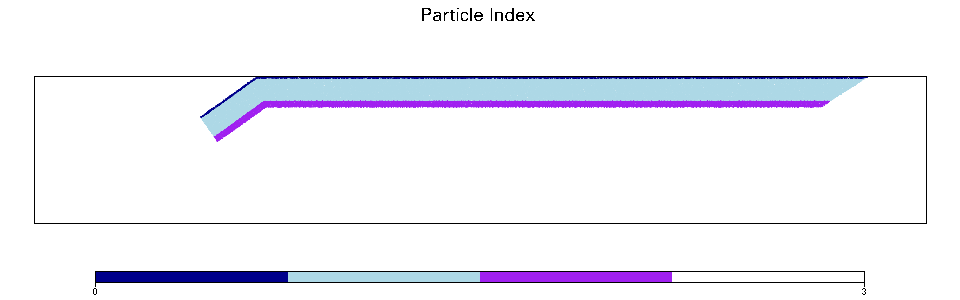

In [53]:
figParticle = glucifer.Figure(figsize=(960,300), title="Particle Index" )
figParticle.append( glucifer.objects.Points(swarm, materialVariable, pointSize=1, 
                                            colours='darkblue lightblue purple white', discrete=True) )
figParticle.show()